In [1]:
# exploring options to optimise particle filter params
# by optimising for accuracy over gazebo log

In [2]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cbl_particle_filter.filter import load_input_log
from cbl_particle_filter.carpet_map import load_map_from_png
from cbl_particle_filter.filter import Pose, CarpetBasedParticleFilter, offline_playback
from cbl_particle_filter.visualisation import plot_map

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
log_dir = "/home/tfanselo/projects/personal/20210106_cbl/logs/pf_tuning_log_gazebo_20210325"
log_file = f"{log_dir}/localiser_input_log.pickle"
map_png = f"{log_dir}/office_map.png"

In [4]:
carpet = load_map_from_png(map_png, cell_size=0.5)

In [5]:
log = load_input_log(log_file)
start_pose = log[0][2]

In [6]:
def perform_playback(
    log,
    carpet_map,
    seed_pose,
    pf_params=dict(),
    ):
    """
    Localise over given log, returning a dataframe of localised poses and
    ground truth
    """
    
    np.random.seed(123)
    
    localised_poses = offline_playback(
        input_data = log,
        carpet = carpet,
        seed_pose = seed_pose,
        **pf_params,
    )    
    
    # convert results to dataframe
    ground_truth_poses = [gt_pose for _, _, gt_pose in log]

    df_data = []
    for ground_truth_pose, localised_pose in zip(ground_truth_poses, localised_poses):
        df_data.append({
            "gt_x":ground_truth_pose.x,
            "gt_y":ground_truth_pose.y,
            "loc_x":localised_pose.x,
            "loc_y":localised_pose.y,
        })
    return pd.DataFrame(df_data)

def plot_results(results_df:pd.DataFrame):    
    plot_map(carpet, show=False)
    plt.plot(results_df.gt_x, results_df.gt_y, color='tab:orange', linewidth=2)
    plt.plot(results_df.loc_x, results_df.loc_y, color='tab:green', marker='o',markersize=3)
    plt.axis('off')
    plt.legend(['ground truth', 'particle filter output'])
    plt.show()
    
def get_playback_error(
    log,
    carpet_map,
    seed_pose,
    plot=False,
    pf_params=dict()
    ):
    """
    Report sum squared position error for playback of the given log
    """
    results_df = perform_playback(
        log,
        carpet_map,
        seed_pose,
        pf_params=pf_params,
    )
    position_errors = np.linalg.norm(np.vstack([results_df.loc_x - results_df.gt_x, results_df.loc_y - results_df.gt_y]),axis=0)
    sum_squared_error = sum(np.power(position_errors,2))
    
    if plot:
        plot_results(results_df)

    return sum_squared_error

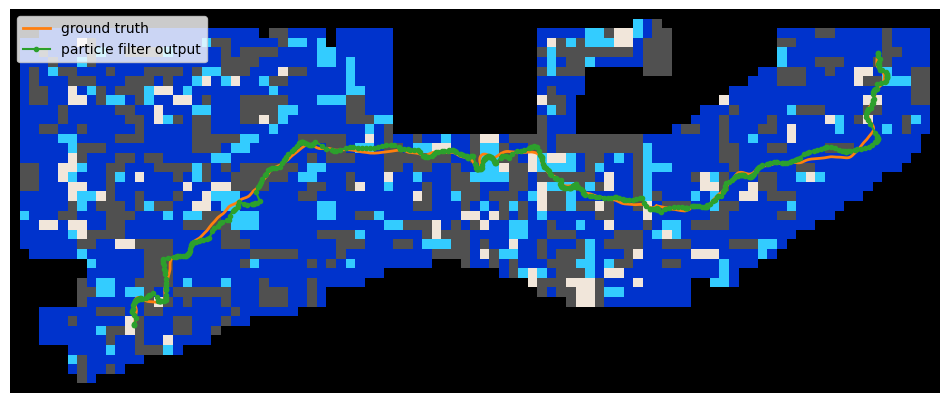

24.59239915503305

In [7]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.05,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

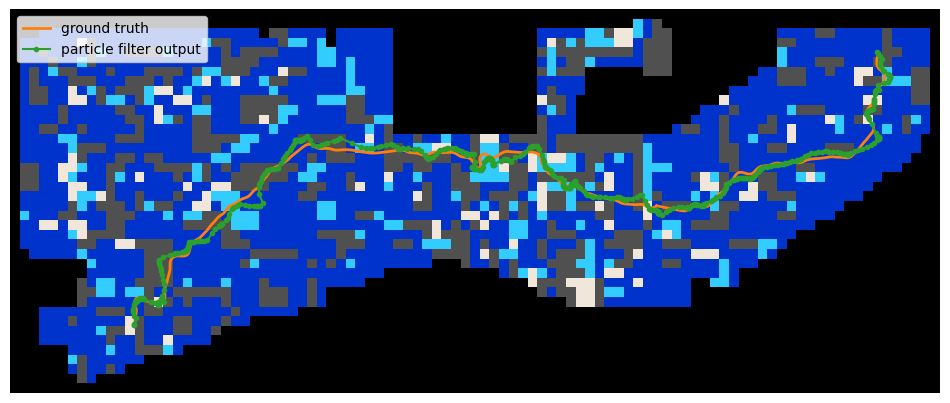

55.237009195496306

In [9]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.1,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

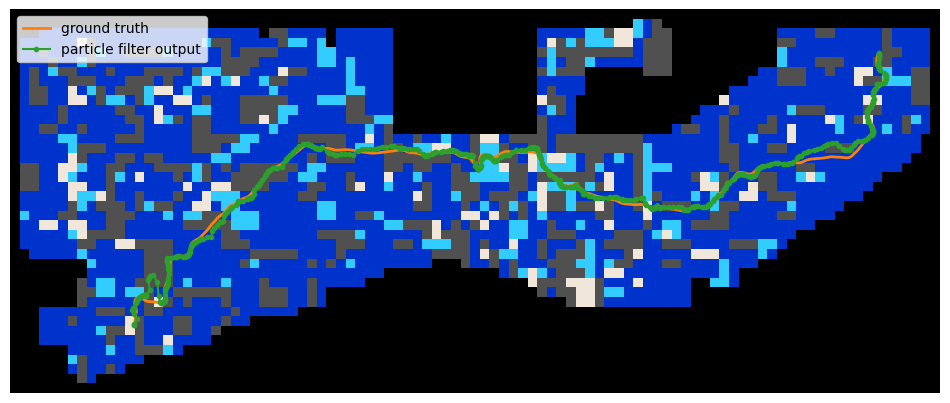

21.635142490065203

In [10]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.01,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

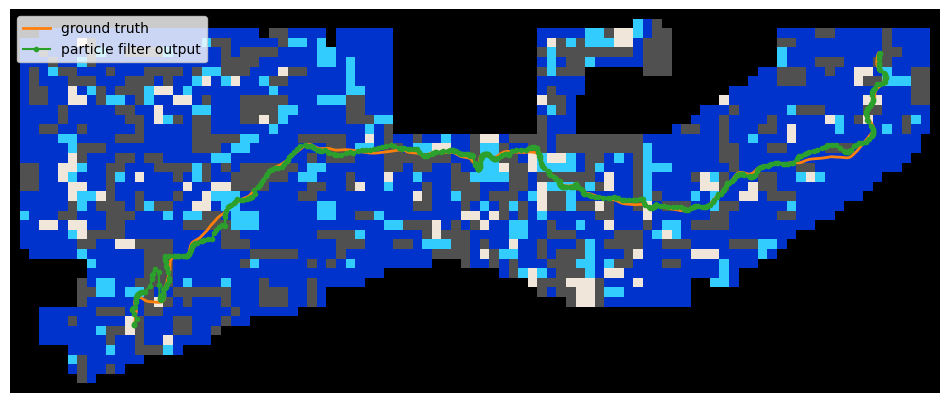

26.06169928507269

In [11]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.0,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

In [ ]:
# Try some parameter value sweeps to look for minima

In [16]:
def test_parameter_range(parameter_name:str, parameter_values:List):
    for parameter_value in parameter_values:
        pf_params = {parameter_name:parameter_value}
        error = get_playback_error(
            log,
            carpet,
            seed_pose=start_pose,
            plot=False,
            pf_params=pf_params,        
        )
        print(f"{parameter_name}={parameter_value},\t{error=}")

In [17]:
test_parameter_range("odom_pos_noise",[0, 0.005, 0.01, 0.02, 0.1, 1.0])

odom_pos_noise=0,	error=36.11475838365856
odom_pos_noise=0.005,	error=25.59857683014618
odom_pos_noise=0.01,	error=20.773676295346988
odom_pos_noise=0.02,	error=24.589833284720598
odom_pos_noise=0.1,	error=56.96220022863522
odom_pos_noise=1.0,	error=159710.8913109472


In [18]:
# looks like a minimum for odom_pos_noise around 0.01

In [19]:
test_parameter_range("odom_heading_noise",[0, 0.005, 0.01, 0.02, 0.1, 1.0])

odom_heading_noise=0,	error=17.764960611198624
odom_heading_noise=0.005,	error=11.395484339183156
odom_heading_noise=0.01,	error=11.720089159816895
odom_heading_noise=0.02,	error=12.867742182590248
odom_heading_noise=0.1,	error=57.562146710270575
odom_heading_noise=1.0,	error=233811.2854618083


In [21]:
# odom_heading_noise also looks good around 0.01

# Note that odometry in this case is generated by the gazebo_ros_diff_drive plugin, which does not appear to 
# add any noise to the simulated output
# https://github.com/ros-simulation/gazebo_ros_pkgs/blob/kinetic-devel/gazebo_plugins/src/gazebo_ros_diff_drive.cpp
# This could lead to significantly different results between simulation and reality.
# Relevant to adding noise to gazebo odom:
# https://blog.lxsang.me/post/id/16

In [22]:
test_parameter_range("resample_proportion",[0, 0.01, 0.1, 1.0])

resample_proportion=0,	error=24.21336682586772
resample_proportion=0.01,	error=1317.5984315283013
resample_proportion=0.1,	error=72029.99024069501
resample_proportion=1.0,	error=94689.17271646268


In [23]:
# resample proportion doesn't appear to help at all.
# My assumption would be that this resampling increases the chance of recovering from loss of localisation,
# at the expense of degrading accuracy in the normal case.

In [25]:
test_parameter_range("weight_fn_p",[0.5, 0.8, 0.9, 0.95, 0.99, 1.0])

weight_fn_p=0.5,	error=18601.208945258066
weight_fn_p=0.8,	error=27.973712596037274
weight_fn_p=0.9,	error=24.59239915503305
weight_fn_p=0.95,	error=24.21336682586772
weight_fn_p=0.99,	error=28.60204172035837
weight_fn_p=1.0,	error=24.41603592818053


In [26]:
# notice multiple local minima, at p=0.95 and p=1.0
# I'd guess these parameter sweeps are partially susceptible to 
# noise / edge cases for particular parameterisations.
# out of interest, plot the last three trajectories, to see what goes wrong when p=0.99

weight_fn_p=0.95


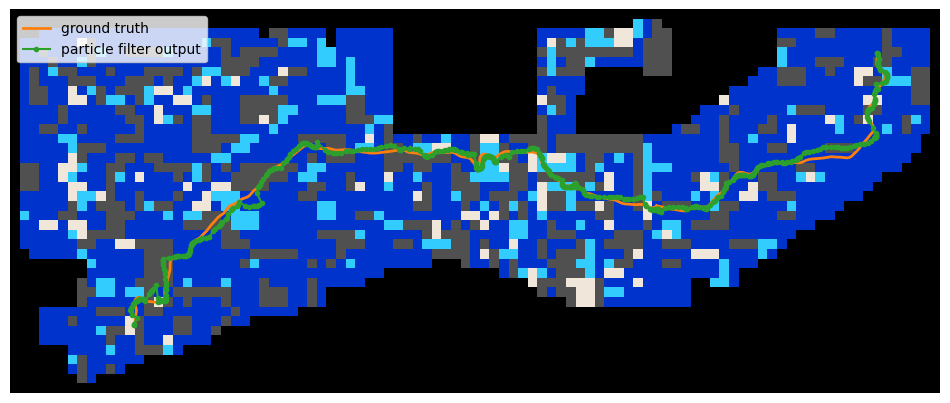

weight_fn_p=0.99


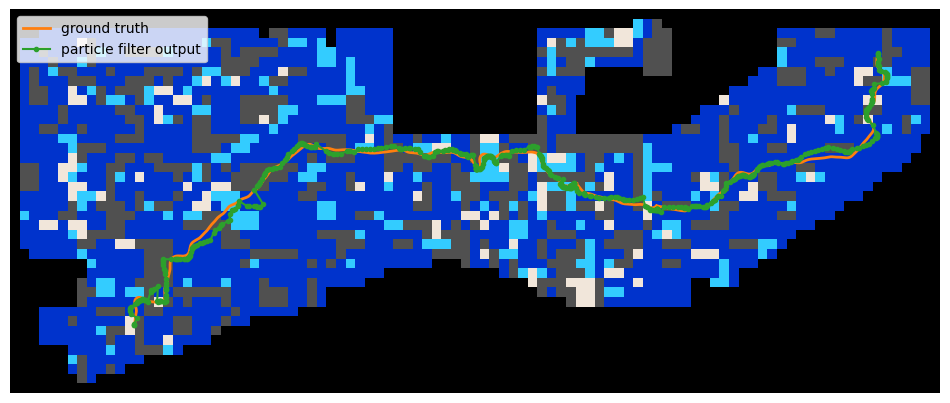

weight_fn_p=1.0


/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))


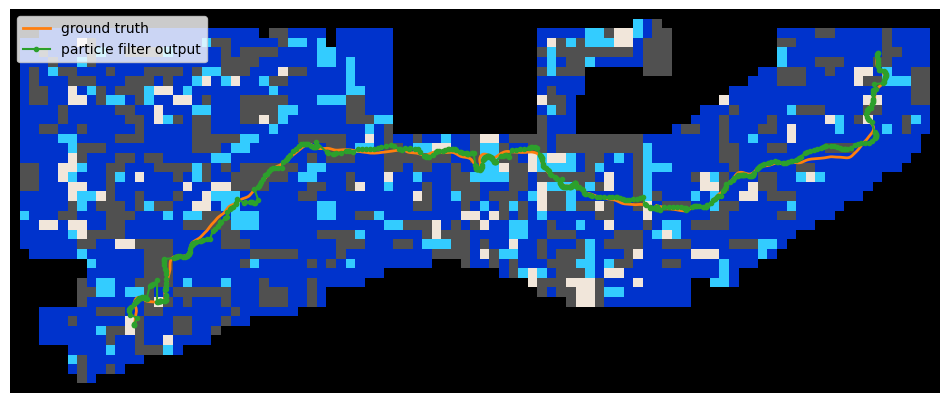

In [30]:
for weight_fn_p in [0.95, 0.99, 1.0]:
    print(f"{weight_fn_p=}")
    get_playback_error(
        log,
        carpet,
        seed_pose=start_pose,
        plot=True,
        pf_params=dict(
            weight_fn_p=weight_fn_p,
        )
    )

In [31]:
# couldnt see any obvious differences in the trajectories.

In [34]:
test_parameter_range("n_particles",[10, 100, 1000, 10000])

n_particles=10,	error=17173.919517912556
n_particles=100,	error=36.76662612418414
n_particles=1000,	error=24.793631352156908
n_particles=10000,	error=22.182160005674735


In [35]:
# more particles = better, but also slower. 10k took quite a while to complete

In [40]:
# more focused particle number testing
test_parameter_range("n_particles",[100, 200, 300, 500, 700, 1000])

n_particles=100,	error=36.76662612418414
n_particles=200,	error=23.269615240497924
n_particles=300,	error=24.723470303902932
n_particles=500,	error=24.21336682586772
n_particles=700,	error=23.07116875705622
n_particles=1000,	error=24.793631352156908


In [41]:
# anything over 200 does not appear to have a large effect on error, although I'd still want to keep the number
# high for general robustness (don't want to overfit this limited dataset)

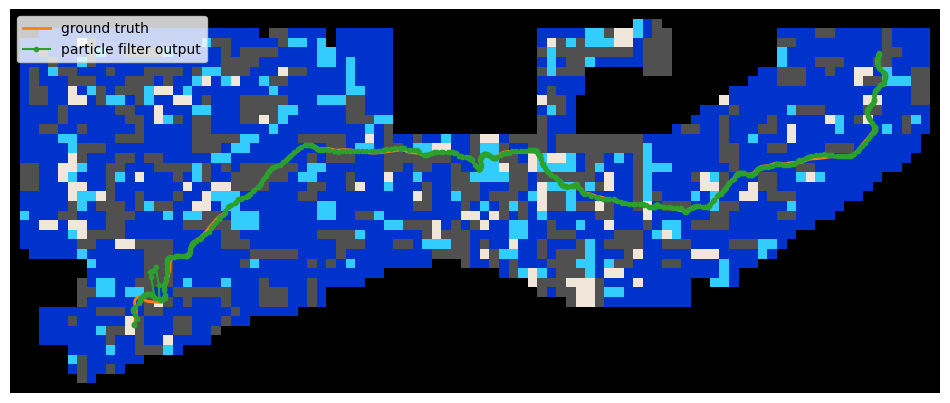

18.5020889824211

In [42]:
# Test current best guess parameters

get_playback_error(
        log,
        carpet,
        seed_pose=start_pose,
        plot=True,
        pf_params=dict(
            odom_pos_noise=0.01,
            odom_heading_noise=0.01,
            resample_proportion=0,
            weight_fn_p = 0.95,
            n_particles = 500
        )
    )

In [43]:
# looks pretty good, except for a position jump around the start of the trajectory.
# I'm also concerned about overfitting to simulated data.
# Will test these parameters in real world and observe performance.